# Process for Revenue Forecast

## **1. Importing all necessary libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,8
from datetime import datetime
pa=10
# plot_acf is to identify (Q): Auto-correlation
# plot_pacf is for partial Auto-correlation value of (p)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#Testing for Stationary time series
from statsmodels.tsa.stattools import adfuller
# For non seasonal data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from matplotlib import pyplot

In [3]:
#Reading excel file
data=pd.read_excel('/kaggle/input/dataset.xlsx')

## **2. Data Preprocessing**

In [4]:
data=data[['Date','Sales']]
data=data.dropna() #Dropping rows with NaN or NaT values
data=data.set_index('Date')
data.index = pd.to_datetime(data.index)
data

,Sales
Date,
2018-11-12,9340627.20
2018-11-13,9442627.20
2018-11-14,9475027.20
2018-11-15,9475027.20
2018-11-16,9496627.20
...,...
2020-06-29,23210928.00
2020-06-30,23350128.00
2020-07-01,23192385.60


In [5]:
#Step to fill missing value
ndf=data.interpolate()
ndf
zi=ndf.size-1

In [6]:
ndf.describe()

,Sales
count,5.980000e+02
mean,1.553307e+07
std,4.576027e+06
min,7.433880e+06
25%,1.236716e+07
50%,1.542254e+07
75%,1.941770e+07
max,2.798935e+07


<AxesSubplot:xlabel='Date'>

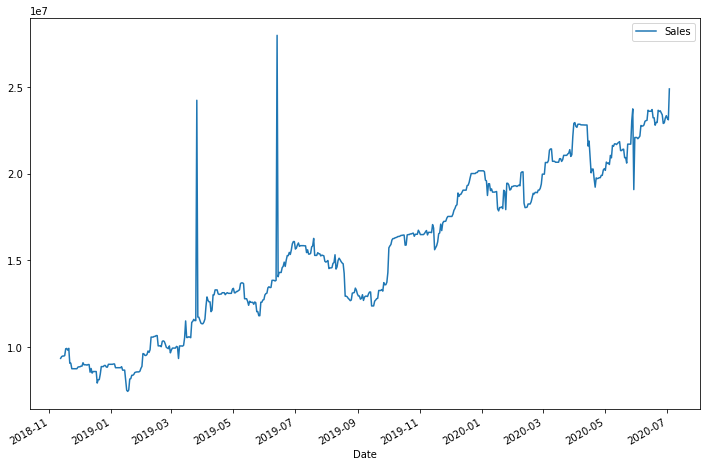

In [7]:
ndf.plot()

<AxesSubplot:xlabel='Date'>

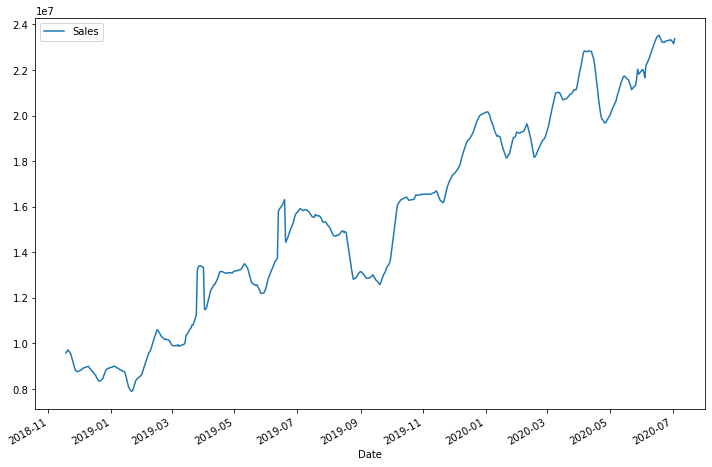

In [8]:
df_mean=ndf.rolling(window=7).mean() #Checking data trend for each week
df_mean.plot()

<AxesSubplot:xlabel='Date'>

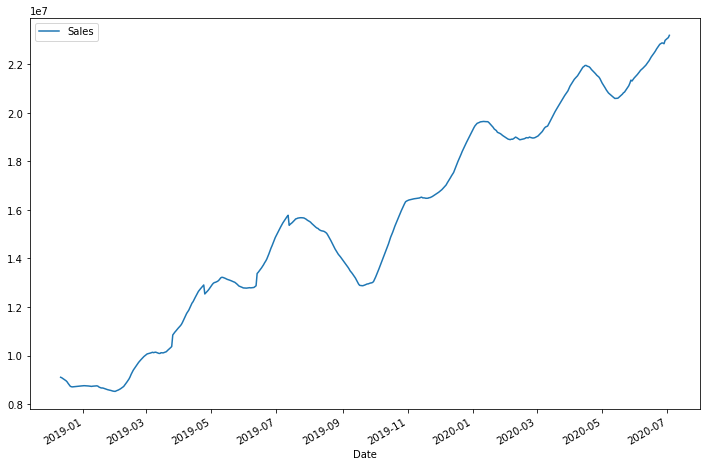

In [9]:
df_mean=ndf.rolling(window=30).mean() #Checking data trend for each month
df_mean.plot()

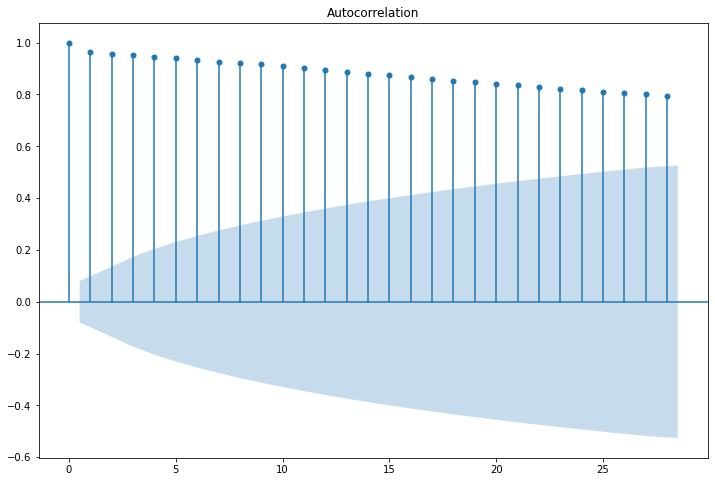

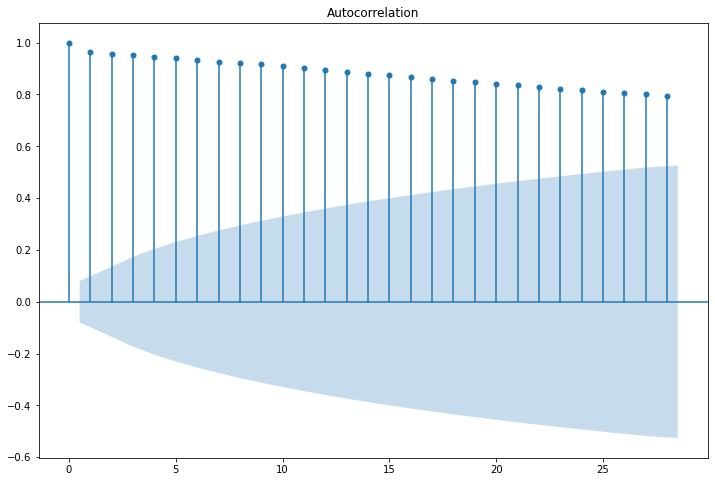

In [10]:
#Plot the autocorrelation function
#Plots lags on the horizontal and the correlations on vertical axis.
plot_acf(ndf)

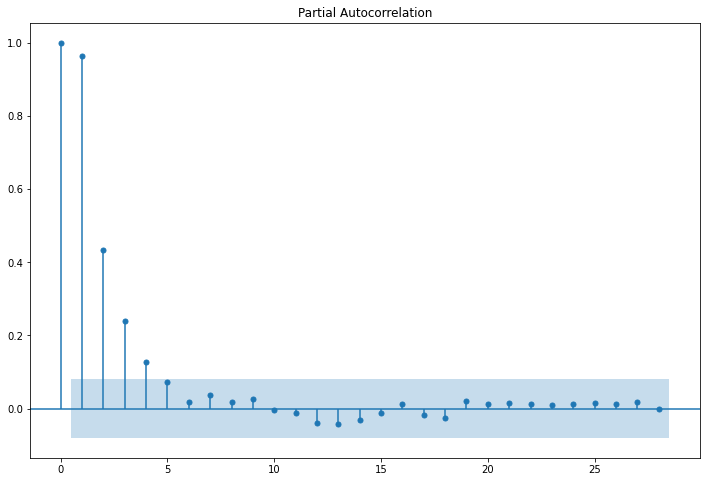

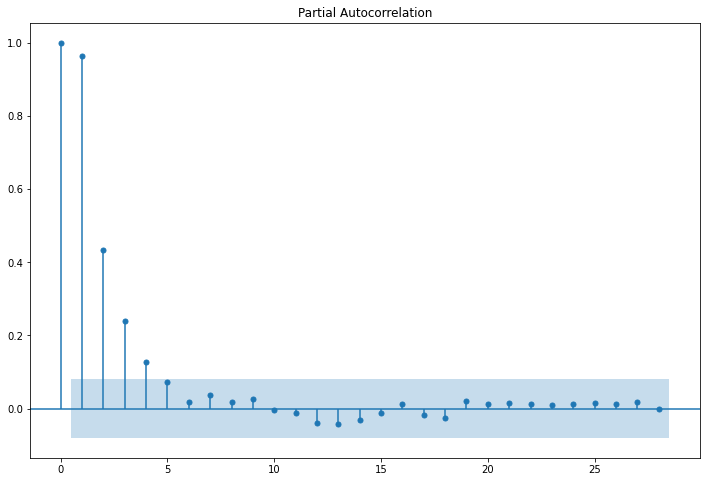

In [11]:
#Partial autocorrelation estimate.
plot_pacf(ndf)

Since this is a non-stationary dataset, summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.

# Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary

In [12]:
#H0: It is non-stationary
#H1: It is stationary
def adfuller_test(sales):
    result=adfuller(sales)
    print(result)
    labels=['ADF Test Statistics','p-value','Lags Used','Number of Observations Used']
    for value,label in zip (result,labels):
        print(label+' : '+str(value))
    if result[1]<=0.05:
        print("Stong Evidence against the Null Hypothesis, Reject the Null Hypothesis hence Stationary")
    else:
        print("Weak against Null hypothesis hence Non stationary")

In [13]:
adfuller_test(ndf['Sales'])

(-0.6508012598800823, 0.8590850250688302, 4, 593, {'1%': -3.4414256033746606, '5%': -2.8664262627821473, '10%': -2.569372254520843}, 17587.649854610096)
ADF Test Statistics : -0.6508012598800823
p-value : 0.8590850250688302
Lags Used : 4
Number of Observations Used : 593
Weak against Null hypothesis hence Non stationary


# Differencing in Time Series Data
Differencing is a method of transforming a time series dataset.

It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality. Differencing is performed by subtracting the previous observation from the current observation.

# Lag Difference
Taking the difference between consecutive observations is called a lag-1 difference.

The lag difference can be adjusted to suit the specific temporal structure.

For time series with a seasonal component, the lag may be expected to be the period (width) of the seasonality.

In [14]:
#Time differencing to make the sales data stationary
ndf['Sales First Difference']=ndf['Sales']-ndf['Sales'].shift(1) #for each day

In [15]:
ndf['Weekly First Difference']=ndf['Sales']-ndf['Sales'].shift(7) #for each week

In [16]:
#Test with dickey Fuller Test
adfuller_test(ndf['Weekly First Difference'].dropna())

(-6.197000295712438, 5.9319753265014476e-08, 15, 575, {'1%': -3.4417738839904657, '5%': -2.8665796253604015, '10%': -2.569453974291115}, 17536.626423993363)
ADF Test Statistics : -6.197000295712438
p-value : 5.9319753265014476e-08
Lags Used : 15
Number of Observations Used : 575
Stong Evidence against the Null Hypothesis, Reject the Null Hypothesis hence Stationary


In [17]:
adfuller_test(ndf['Sales First Difference'].dropna())

(-18.34906224629587, 2.2383759851971716e-30, 3, 593, {'1%': -3.4414256033746606, '5%': -2.8664262627821473, '10%': -2.569372254520843}, 17556.903487386902)
ADF Test Statistics : -18.34906224629587
p-value : 2.2383759851971716e-30
Lags Used : 3
Number of Observations Used : 593
Stong Evidence against the Null Hypothesis, Reject the Null Hypothesis hence Stationary


<AxesSubplot:xlabel='Date'>

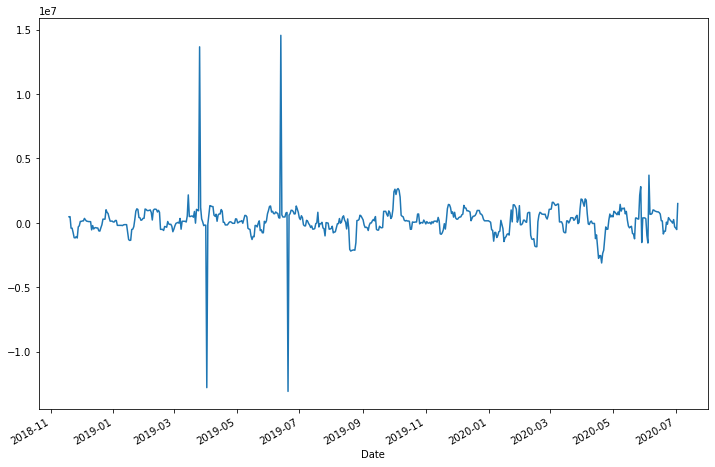

In [18]:
ndf['Weekly First Difference'].plot()

<AxesSubplot:xlabel='Date'>

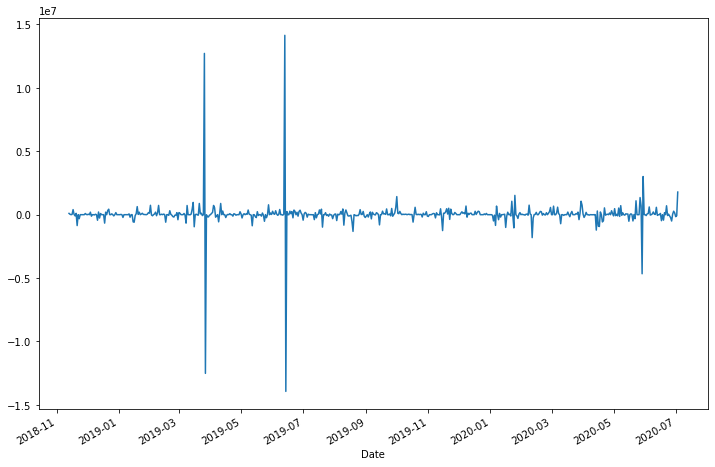

In [19]:
ndf['Sales First Difference'].plot()

<AxesSubplot:xlabel='Date'>

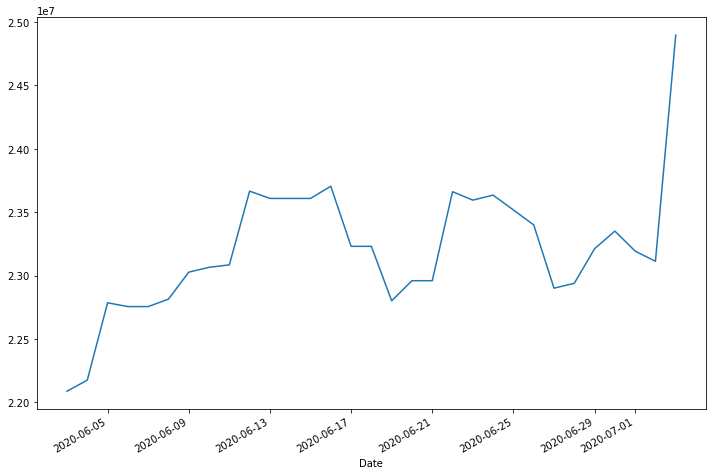

In [20]:
ndf['Sales'].tail(30).plot()

In [21]:
#For lags calculation we will need Auto-Correlation plot
# P,D,Q for ARIMA where P= AR lags D=differencing Q=MA lags
#Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q)
#where parameters p, d, and q are non-negative integers,
#p is the order (number of time lags) of the autoregressive model,
#d is the degree of differencing (the number of times the data have had past values subtracted),
#q is the order of the moving-average model.


# SARIMA Model 
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

In [22]:
model=sm.tsa.statespace.SARIMAX(ndf['Sales'],order=(1,1,1),seasonal_order=(1,1,1,7))
results=model.fit(disp=True)
print(results.aic)
f1=results.get_forecast(steps=90)
print(f1.summary_frame(alpha=0.10))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18118.974406174842
Sales          mean       mean_se  mean_ci_lower  mean_ci_upper
598    2.379280e+07  1.387397e+06   2.151074e+07   2.607487e+07
599    2.400266e+07  1.507952e+06   2.152230e+07   2.648302e+07
600    2.402897e+07  1.631582e+06   2.134525e+07   2.671268e+07
601    2.409349e+07  1.746018e+06   2.122155e+07   2.696544e+07
602    2.402867e+07  1.853420e+06   2.098006e+07   2.707727e+07
..              ...           ...            ...            ...
683    2.677620e+07  7.683184e+06   1.413848e+07   3.941391e+07
684    2.679693e+07  7.747410e+06   1.405358e+07   3.954029e+07
685    2.685924e+07  7.811102e+06   1.401112e+07   3.970736e+07
686    2.679710e+07  7.874276e+06   1.384507e+07   3.974913e+07
687    2.694878e+07  7.936947e+06   1.389366e+07   4.000389e+07

[90 rows x 4 columns]


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:xlabel='Date'>

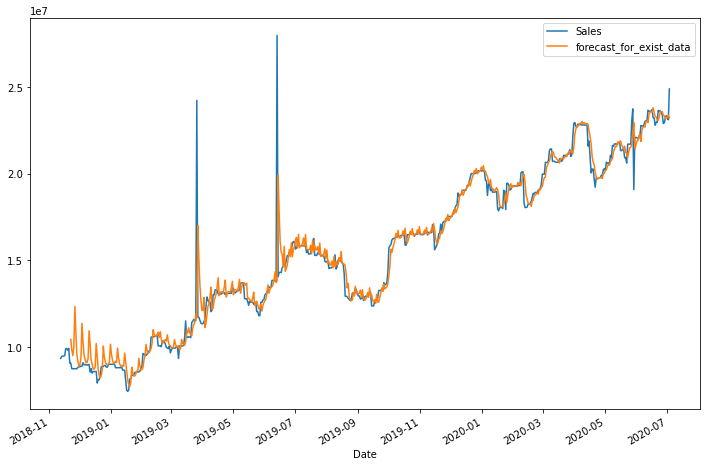

In [23]:
#To check how well does the model fit
ndf['forecast_for_exist_data']=results.predict(start=10,end=zi,Dynamic=True)
ndf[['Sales','forecast_for_exist_data']].plot(figsize=(12,8))

Predicting and comparing the values for last 30 days of provided data

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


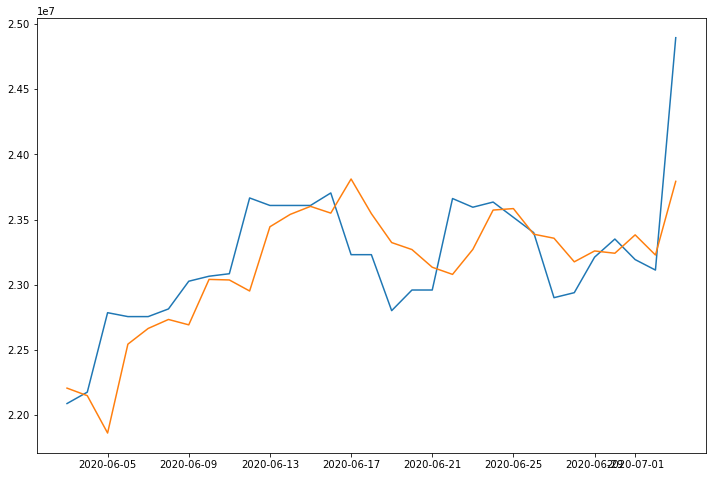

In [24]:
index_f_dates=pd.date_range(start='2020-06-03',end='2020-07-03')
d1=[]
d=results.predict(start=len(ndf['Sales'])-30,end=len(ndf['Sales']),typ='levels')
d1=pd.DataFrame(d)
d1['Date']=index_f_dates
d1=d1.set_index('Date')
pyplot.plot(ndf['Sales'][-30:])
pyplot.plot(d1)
pyplot.show()

## Predicting the values for next 90days using SARIMA Model

In [25]:
future_dates=[ndf.index[-1]+ DateOffset(days=x)for x in range(0,90)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=ndf.columns)
future_df=pd.concat([ndf,future_datest_df])
index_f_dates=pd.date_range(start='2020-07-04', periods=91, freq='D')
d=results.predict(start=len(future_df)-90,end=len(future_df),typ='levels',dynamic=True)
d1=pd.DataFrame(d)
d1['Date']=index_f_dates
d1=d1.set_index('Date')
future_df['Forecast_for_next_90_Days']=d1
future_df.to_excel('Predict_sales_for_next_90_days_SARIMA.xlsx')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:>

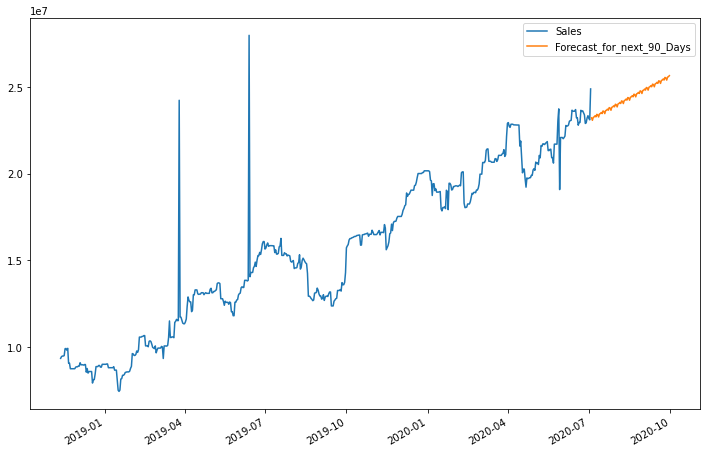

In [26]:
future_df[['Sales', 'Forecast_for_next_90_Days']].plot(figsize=(12, 8))

In [27]:
ndf=ndf.dropna()

# ARIMA Model
ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

In [28]:
model=ARIMA(ndf['Sales First Difference'],order=(1,1,0))
results=model.fit(disp=0)
print(results.summary())

                                ARIMA Model Results                                 
Dep. Variable:     D.Sales First Difference   No. Observations:                  587
Model:                       ARIMA(1, 1, 0)   Log Likelihood               -9183.261
Method:                             css-mle   S.D. of innovations        1506011.809
Date:                      Sun, 21 Mar 2021   AIC                          18372.523
Time:                              12:32:27   BIC                          18385.648
Sample:                                   1   HQIC                         18377.637
                                                                                    
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           3037.9740   3.75e+04      0.081      0.935   -7.05e+04    7.66e+04
ar.L1.D.Sales First Dif

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

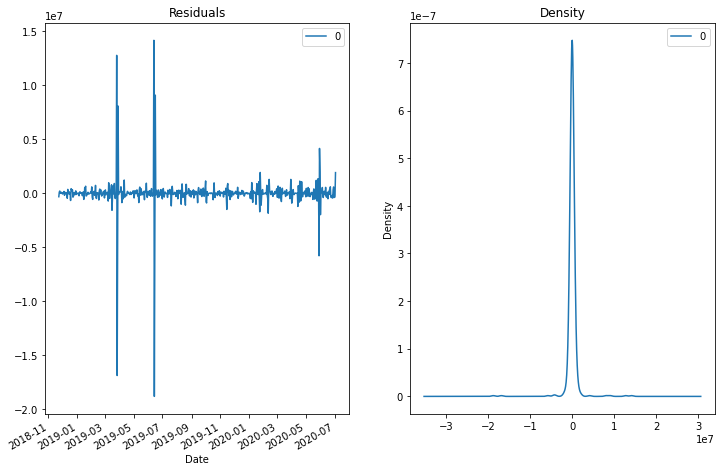

In [29]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

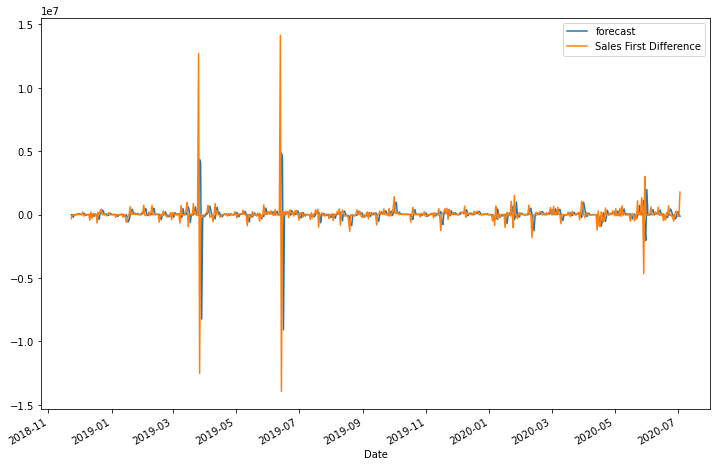

In [30]:
# Actual vs Fitted
results.plot_predict(dynamic=False)
plt.show()

Splitting the data into train and test data to check the accuracy of the model

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

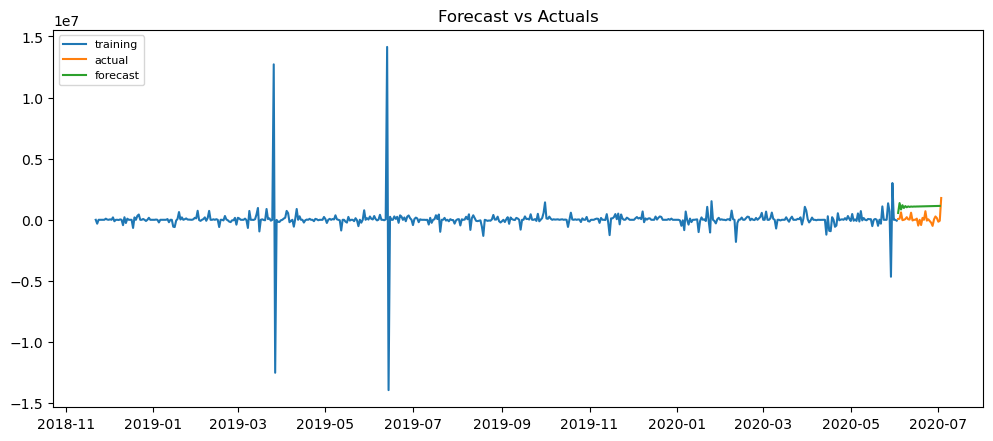

In [31]:
# Create Training and Test
train = ndf['Sales First Difference'][:-30]
test = ndf['Sales First Difference'][-30:]
model = ARIMA(train, order=(3,2,0))  
fitted = model.fit(disp=0)  
# Forecast
fc= results.forecast(steps=30)[0]
# Make as pandas series
index_f_dates=pd.date_range(start='2020-06-03',end='2020-07-02')
pre=pd.DataFrame(fc)
pre['Date']=index_f_dates
pre=pre.set_index('Date')
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pre, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Predicting the values for next 90days using ARIMA Model

In [32]:
start=len(ndf['Sales First Difference'])
predict=results.predict(start=start,end=start+90,typ='levels')
index_f_dates=pd.date_range(start='2020-07-04',end='2020-10-02')
pre=pd.DataFrame(predict)
pre['Date']=index_f_dates
pre=pre.set_index('Date')
future_df['Forecast_for_next_90_Days']=pre
future_df.to_excel('Predict_sales_for_next_90_days_ARIMA.xlsx')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:>

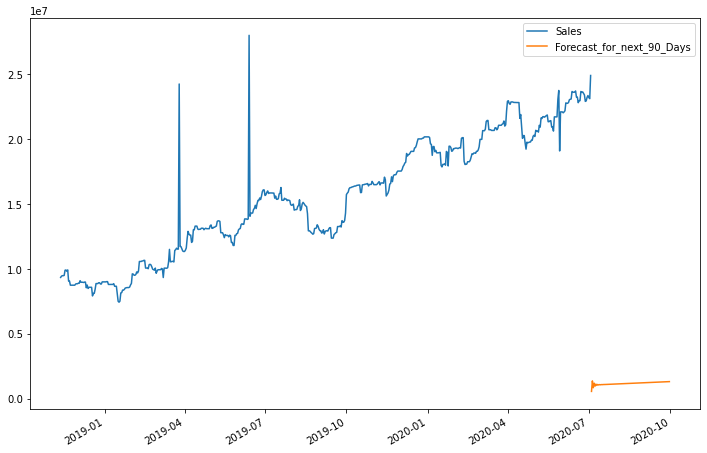

In [33]:
future_df[['Sales', 'Forecast_for_next_90_Days']].plot(figsize=(12, 8))